# Original model for classifying radio modulation 
## Purely built using only Pytorch and run on GPU

In [ ]:
#TODO: write tutorial for building model (non-quantized) using only pytorch. 
#This is only for demonstration purposes, showing the structure of the model
#This model is not used in any stages of the transformation
#Instead the Brevitas quantized model will be used for transformation

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Using cuda 
assert torch.cuda.is_available(), 'Cuda not available'
gpu = 'cuda'

# The RadioML 2021 Dataset <a id='load_dataset'></a>

The dataset comes in hdf5 format and exhibits the following structure:
- 27 modulations
- 26 SNRs per modulation (-20 dB through +30 dB in steps of 2)
- 4096 frames per modulation-SNR combination
- 1024 complex time-series samples per frame
- Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape
- 2.875.392 frames in total
- Value is in int8 [-128, 127]



In [7]:
# Check if dataset is present
import os.path
dataset_path = "datasets/RADIOML_2021_07_INT8.hdf5"
os.path.isfile(dataset_path)

True

In [25]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_21_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_21_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
        self.num_classes=len(self.mod_classes)
        # print(np.unique(self.snr))
        # print(self.data.shape)
        # print(np.min(self.data),'   ',np.max(self.data),'  ',self.data.dtype)
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB, with step of 2 --> 26 snrs

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2021)

        train_indices = []
        test_indices = []
        for mod in range(0, len(self.mod_classes)): # all modulations (0 to 26)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # raw dataset holds frames strictly ordered by modulation and SNR
                # We order the dataset to each mod-snr pair combination for better access of each frame
                # Specifically we divide the dataset into 27 mods group,
                #   and for each group we divide into 26 SNRs,
                # For each modulation-snr pair combination, we have 4096 frames. (27*26*4096 = 2875392)
                # For better analogy, its basically a triple for-loop, with the outer most loop being 27 mods,
                #                                                           then the middle being 26 SNRs,
                #                                                           then inner most being 4096 samples
                # [0...26][0...25][0...4095]
                start_idx = 26*4096*mod + 4096*snr_idx 
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_21_dataset(dataset_path) 

print('Value range: ', np.min(dataset.data),'   ',np.max(dataset.data),'  ',dataset.data.dtype) #The total range of int8 is [-127,128]
print('Total mods: ',dataset.num_classes)
print('Number of SNRs: ',len(dataset.snr_classes))
print('Number of frames per each SNR-Modulation combination: ',dataset.data.shape[0]/(dataset.num_classes*len(dataset.snr_classes)))
print('SNRs: ',dataset.snr_classes,' \n')
print('Total size: ',dataset.data.shape)
print('Training set size: ',len(dataset.train_sampler))
print('Test/Val set size: ',len(dataset.test_sampler))

Value range:  -112     127    int8
Total mods:  27
Number of SNRs:  26
Number of frames per each SNR-Modulation combination:  4096.0
SNRs:  [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.]  

Total size:  (2875392, 1024, 2)
Training set size:  2587572
Test/Val set size:  287820


Modulation: 8FSK, SNR: 30.0 dB, Index: 2871419


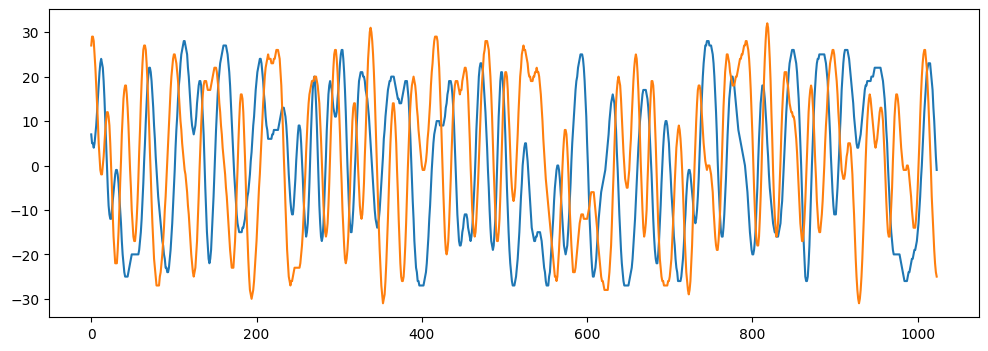

In [30]:
# Inspect a frame
mod = 26 # 0 to 26
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))